In [1]:
import numpy as np
from scipy.signal import savgol_filter
from math import ceil
from scipy.signal import csd
from scipy.optimize import least_squares
from itertools import product, combinations

import noise_plot_utils as noise_plt


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')



class noise(object):
    
    
    def __init__(self, traces, sampleRate, channNames, traceGain = 1.0, name = None, freqs = None, time = None \
                 , PSD = None , real_PSD = None, imag_PSD = None, corrCoeff = None, unCorrNoise = None \
                 , corrNoise = None, real_CSD = None, imag_CSD = None, real_CSD_std = None, imag_CSD_std = None \
                 , CSD = None, freqs_CSD = None, sigR = None, sigC = None, reA = None, imA = None \
                 , results = None):
        self.traces = traces # 3d numpy array. dimention zero is number of traces, d-1 is channel number, 
        #d-3 is number of data points per trace
        self.sampleRate = sampleRate
        self.channNames = channNames
        self.time = time # array of x-values in units of time [sec]
        self.name = name
        
         #list of channel names
        self.traceGain = traceGain #convertion of trace amplitude from ADC bins to amperes 
        self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = 1/sampleRate)
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        self.corrCoeff = corrCoeff
        self.unCorrNoise = unCorrNoise
        self.corrNoise = corrNoise
        self.sigR = sigR
        self.sigC = sigC
        self.reA = reA
        self.imA = imA
        self.real_CSD = real_CSD
        self.imag_CSD = imag_CSD
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
        self.CSD = CSD
        self.freqs_CSD = freqs_CSD
        
        self.results = results
        
        
        
        
    
    def set_freqs(self, freqs):
        self.freqs = freqs
    def set_traceGain(self, traceGain):
        self.traceGain = traceGain
    def set_sampleRate(self, sampleRate):
        self.sampleRate = sampleRate
    def set_channNames(self, channNames):
        self.channNames = channNames
    def set_name(self, name):
        self.name = name
        
        
    
        
        
    #def calculate_freqs(self):
    #    dt = 1/self.sampleRate
    #    self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = dt)

    
    def caclulate_PSD(self): 
        # get shape of traces to use for iterating
        traceShape = self.traces.shape
        #check if length of individual trace is odd of even
        if traceShape[2] % 2 != 0:
            lenPSD = int((traceShape[2] + 1)/2)
        else:
            lenPSD = int(traceShape[2]/2 + 1)
            
        # initialize empty numpy array to hold the PSDs 
        PSD = np.empty(shape = (traceShape[1], lenPSD))
        real_PSD = np.empty(shape = (traceShape[1], lenPSD))
        imag_PSD = np.empty(shape = (traceShape[1], lenPSD))
 
        fft = np.fft.rfft(self.traces)
        PSD_chan = np.abs(fft)**2
        real_PSD_chan = np.real(fft)**2
        imag_PSD_chan = np.imag(fft)**2
        # take the average of the PSD's for each trace, normalize, and fold over the 
        # negative frequencies since they are symmetric
        PSD = np.mean(PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate) 
        real_PSD = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
        imag_PSD = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)  
               
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        
        
    def calculate_corrCoeff(self):
        nsizeMatrix = self.traces.shape[1]
        if self.traces.shape[2] % 2 != 0:
            lenPSD = int((self.traces.shape[2] + 1)/2)
        else:
            lenPSD = int(self.traces.shape[2]/2 + 1)
                
        nDataPoints = self.traces.shape[0]
        #initialize empty array                           
        corr_coeff = np.empty(shape=(lenPSD,nsizeMatrix,nsizeMatrix)) 
        

        traces_fft_chan = np.abs(np.fft.rfft(traces))
        traces_fft_chan = np.swapaxes(traces_fft_chan, 0,1)
        for n in range(lenPSD):
            corr_coeff[n] = np.corrcoef(traces_fft_chan[:,:,n])
        
        self.corrCoeff = np.swapaxes(corr_coeff, 0, 2)
        
        
    
        

            
            
            
        
######################### decorrelation of noise ##########
    def calculate_CSD(self, lgc_full_CSD =  True, lenCSD = 256):
        
        
        def fill_negatives(arr):
            '''
            Simple helper function to smooth out wild values
            '''
            zeros = np.array(arr <= 0)
            inds_zero = np.where(zeros)[0]
            inds_not_zero = np.where(~zeros)[0]
            good_vals = arr[~zeros]
            
            
            if len(good_vals) != 0:
                arr[zeros] = np.interp(inds_zero, inds_not_zero, good_vals)
    
            return arr
            
            
        
        
        traceShape = self.traces.shape
        if lgc_full_CSD:
            lenCSD = traceShape[2]
        else:
            lenCSD = lenCSD
            
        if lenCSD % 2 != 0:
            nFreqs = int((lenCSD + 1)/2)
        else:
            nFreqs = int(lenCSD/2 + 1)
       
        nRows = traceShape[1]
        nTraces = traceShape[0]
           
        # initialize the S_ij matrix
        trace_CSD = np.zeros(shape=(nRows,nRows,nTraces,nFreqs),dtype = np.complex128)
        
        CSD_mean = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.complex128)
        real_CSD_mean = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        imag_CSD_mean = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        
        real_CSD_std = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        imag_CSD_std = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        
        for iRow, jColumn in product(list(range(nRows)),repeat = 2):
            for n in range(nTraces):
                freqs ,temp_CSD = csd(self.traces[n,iRow,:],self.traces[n,jColumn,:] \
                                           , nperseg = lenCSD, fs = self.sampleRate, nfft = lenCSD )            

                trace_CSD[iRow][jColumn][n] = temp_CSD
                
            CSD_mean[iRow][jColumn] =  np.mean(trace_CSD[iRow][jColumn],axis = 0)
            real_CSD_mean[iRow][jColumn] = fill_negatives(np.mean(np.real(trace_CSD[iRow][jColumn]),axis = 0))
            imag_CSD_mean[iRow][jColumn] = fill_negatives(np.mean(np.imag(trace_CSD[iRow][jColumn]),axis = 0))   
            real_CSD_std[iRow][jColumn] = fill_negatives(np.std(np.real(trace_CSD[iRow][jColumn]),axis = 0))
            imag_CSD_std[iRow][jColumn] = fill_negatives(np.std(np.imag(trace_CSD[iRow][jColumn]),axis = 0))
            
        self.freqs_CSD = freqs
        self.CSD = CSD_mean
        self.real_CSD = real_CSD_mean
        self.imag_CSD = imag_CSD_mean
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
        
    def calculate_unCorrelated_noise(self, freq_range = [0,-1] , lgc_full_CSD =  True, lenCSD = 256):
        
        
        
        if self.real_CSD == None:
            print('calculating CSD')
            self.calculate_CSD(lgc_full_CSD , lenCSD )
        if self.corrCoeff == None:
            print('calculating correlation coefficients')
            self.calculate_corrCoeff()
            
        traceShape = self.traces.shape
        nRows = traceShape[1]
        nTraces = traceShape[0]
        
        freqs = self.freqs_CSD[freq_range[0]:freq_range[1]]
        fit_Fails = np.zeros(shape = (freqs.shape[0]), dtype = bool)
        results = []
        nFail = 0
        
        
        
        def equations(parameters,lgcReal, i , j):
            reA = parameters[0:nRows]
            imA = parameters[nRows:nRows*2]
            sigR = parameters[nRows*2:-1] 
            sigC = parameters[-1]
            if lgcReal:
                if i == j:
                    return 2.0*(reA[i]*reA[j] + imA[i]*imA[j])*sigC + 2.0*sigR[i]
                else:
                    return 2.0*(reA[i]*reA[j] + imA[i]*imA[j])*sigC
            else:
                return 2.0*(imA[i]*reA[j]-reA[i]*imA[j])*sigC
        
        def residual(parameters):            
            res = list()            
            for iRow in range(nRows):
                for jColumn in range(nRows):
                    weight = (self.real_CSD_std[iRow][jColumn][iFreq])/np.sqrt(nTraces)                                         
                    if iRow >= jColumn:                                                                                                   
                        temp = (self.real_CSD[iRow][jColumn][iFreq] - equations(parameters,  True, iRow,jColumn))                                         
                    else:                        
                        temp = (self.imag_CSD[iRow][jColumn][iFreq] - equations(parameters,  False, iRow,jColumn))                                                                        
                    res.append(temp/weight)
            res_ret = np.asarray(res)                      
            return res_ret
    
        def get_guess(iFreq):
            '''
            Returns a list for the initial guess p0 and bounds, for a given frequency
            '''        
            np0 = nRows*3 + 1        
            p0 = np.zeros(shape = np0, dtype = np.float64) 
            sigR0 = np.zeros(shape = nRows)
            sigC0 = []
            reA0 = np.ones(shape = nRows)*0.5
            imA0 = np.ones(shape = nRows)*0.5
            for iRow in range(nRows):
                for jColumn in range(nRows):
                    if iRow != jColumn:
                        sigC0.append(np.abs(self.CSD[iRow][jColumn][iFreq])/(2.0*self.corrCoeff[iRow][jColumn][iFreq]))
            sigC0 = np.array(sigC0)
            sigC0 = np.mean(sigC0, axis = 0)
            sigC0 = np.array([sigC0])
            for ii in range(nRows):
                sigR0[ii] = np.abs(self.CSD[ii][ii][iFreq])/2 - sigC0
            p0 = np.concatenate((reA0,imA0,sigR0,sigC0))
            imag_uppers = np.ones_like(imA0)
            #imag_uppers[0] = .1 #this is to fix the phase of one term
            bounds_lower = np.concatenate((np.zeros_like(reA0),np.zeros_like(imA0), sigR0/1000.0 - 1.0, sigC0/1000.0 - 1.0))
            bounds_upper = np.concatenate((np.ones_like(reA0),imag_uppers, sigR0*1000.0 + 1.0, sigC0*1000.0 + 1.0))
            bounds = (bounds_lower, bounds_upper)
            
            return p0, bounds
                
                
            
        def results_to_variable(results):
            variables = np.zeros(shape = (len(results),nRows*3+1))
            corr_noise = np.zeros(shape = (nRows, len(results)))
            unCorr_noise = np.zeros(shape = (nRows, len(results)))
            for ii, res in enumerate(results):
                variables[ii] = results[ii]['x'] 
            reA = np.swapaxes(variables[:,0:nRows],0,1)
            imA = np.swapaxes(variables[:,nRows:nRows*2],0,1)
            sigR = np.swapaxes(variables[:,nRows*2:-1],0,1)
            sigC = variables[:,-1]
            
            for ii in range(nRows):
                corr_noise[ii] = 2*(reA[ii]**2 + imA[ii]**2)*sigC
                unCorr_noise[ii] = 2*sigR[ii]
            
            return reA, imA, sigR, sigC, corr_noise, unCorr_noise
            
           
    
        for iFreq in range(freqs.shape[0]):

            if iFreq % 50 == 0: #to speed up and not print so many times

                percentDoneStr = str(round((iFreq+1)/(freqs.shape[0]),3)*100.0)

                print('\n Fitting frequency bin ', iFreq , ' out of ',freqs.shape[0])

                print('\n ====== ', percentDoneStr ,'percent Done ================ ')

            p0, bounds = get_guess(iFreq)


            popt1 = least_squares(residual,p0,jac = 'cs',bounds=bounds,x_scale = 'jac' \
                                  ,loss='linear',max_nfev=1000,verbose=0,xtol=1.0e-17,ftol=1.0e-17,f_scale=1.0)

            if not popt1['success']:
                fit_Fails[iFreq] = True
            if np.any(popt1['active_mask'] != 0):
                fit_Fails[iFreq] = True

            results.append(popt1)
            reA, imA, sigR, sigC,corr_noise, unCorr_noise = results_to_variable(results)
            
        self.sigR = sigR[:,~fit_Fails]
        self.sigC = sigC[~fit_Fails]
        self.reA = reA[:,~fit_Fails]
        self.imA = imA[:,~fit_Fails]
        self.results = results
        self.fit_Fails = fit_Fails
        self.corrNoise = corr_noise[:,~fit_Fails]
        self.unCorrNoise = unCorr_noise[:,~fit_Fails]
        self.freqs_fit = freqs[~fit_Fails]
    
    
    
    
    
    
    
    
    
    
    
    ############# plotting
    def plot_PSD(self, lgc_overlay = True, lgcSave = False, savePath = None):

        noise_plt.plot_PSD(self,lgc_overlay, lgcSave, savePath)
        
                   
    def plot_corrCoef(self, lgcSave = False, savePath = None):

        
        noise_plt.plot_corrCoef(self, lgcSave, savePath)
        
                      
    def plot_CSD(self, whichCSD = ['01'],lgcReal = True,lgcSave = False, savePath = None):
        
        noise_plt.plot_CSD(self, whichCSD, lgcReal, lgcSave, savePath)
        
    def plot_deCorrelatedNoise(self, lgc_overlay = False, lgcData = True,lgcUnCorrNoise = True, lgcCorrelated = False \
                               , lgcSum = False,lgcSave = False, savePath = None):
        noise_plt.plot_deCorrelatedNoise(self, lgc_overlay, lgcData,lgcUnCorrNoise, lgcCorrelated \
                               , lgcSum,lgcSave, savePath)
        
    
    
    

### Load test traces

In [2]:

import pickle as pkl    
with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', "rb") as f:
        traces = pkl.load(f,fix_imports=True,encoding='latin1')

### Initialize noise object

In [3]:
sampleRate = 625e3
channels = [ 'PCS1' , 'PES1' , 'PFS1' , 'PAS2' , 'PBS2' , 'PES2' , 'PDS2' ]
g124_noise = noise(traces, sampleRate, channels)
g124_noise.set_name('G124 SLAC Run 37 Pulse Tube On')


### Calculate PSD and correlation coefficients

In [ ]:

g124_noise.caclulate_PSD()
g124_noise.calculate_corrCoeff()

# Test correlated noise fit


In [ ]:
g124_noise.calculate_unCorrelated_noise(freq_range=[0,1000])

calculating CSD


/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:203: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))



 Fitting frequency bin  0  out of  1000

 ======  0.1 percent Done ================ 

 Fitting frequency bin  50  out of  1000

 ======  5.1 percent Done ================ 

 Fitting frequency bin  100  out of  1000

 ======  10.100000000000001 percent Done ================ 

 Fitting frequency bin  150  out of  1000

 ======  15.1 percent Done ================ 

 Fitting frequency bin  200  out of  1000

 ======  20.1 percent Done ================ 


UnboundLocalError: local variable 'ichan' referenced before assignment

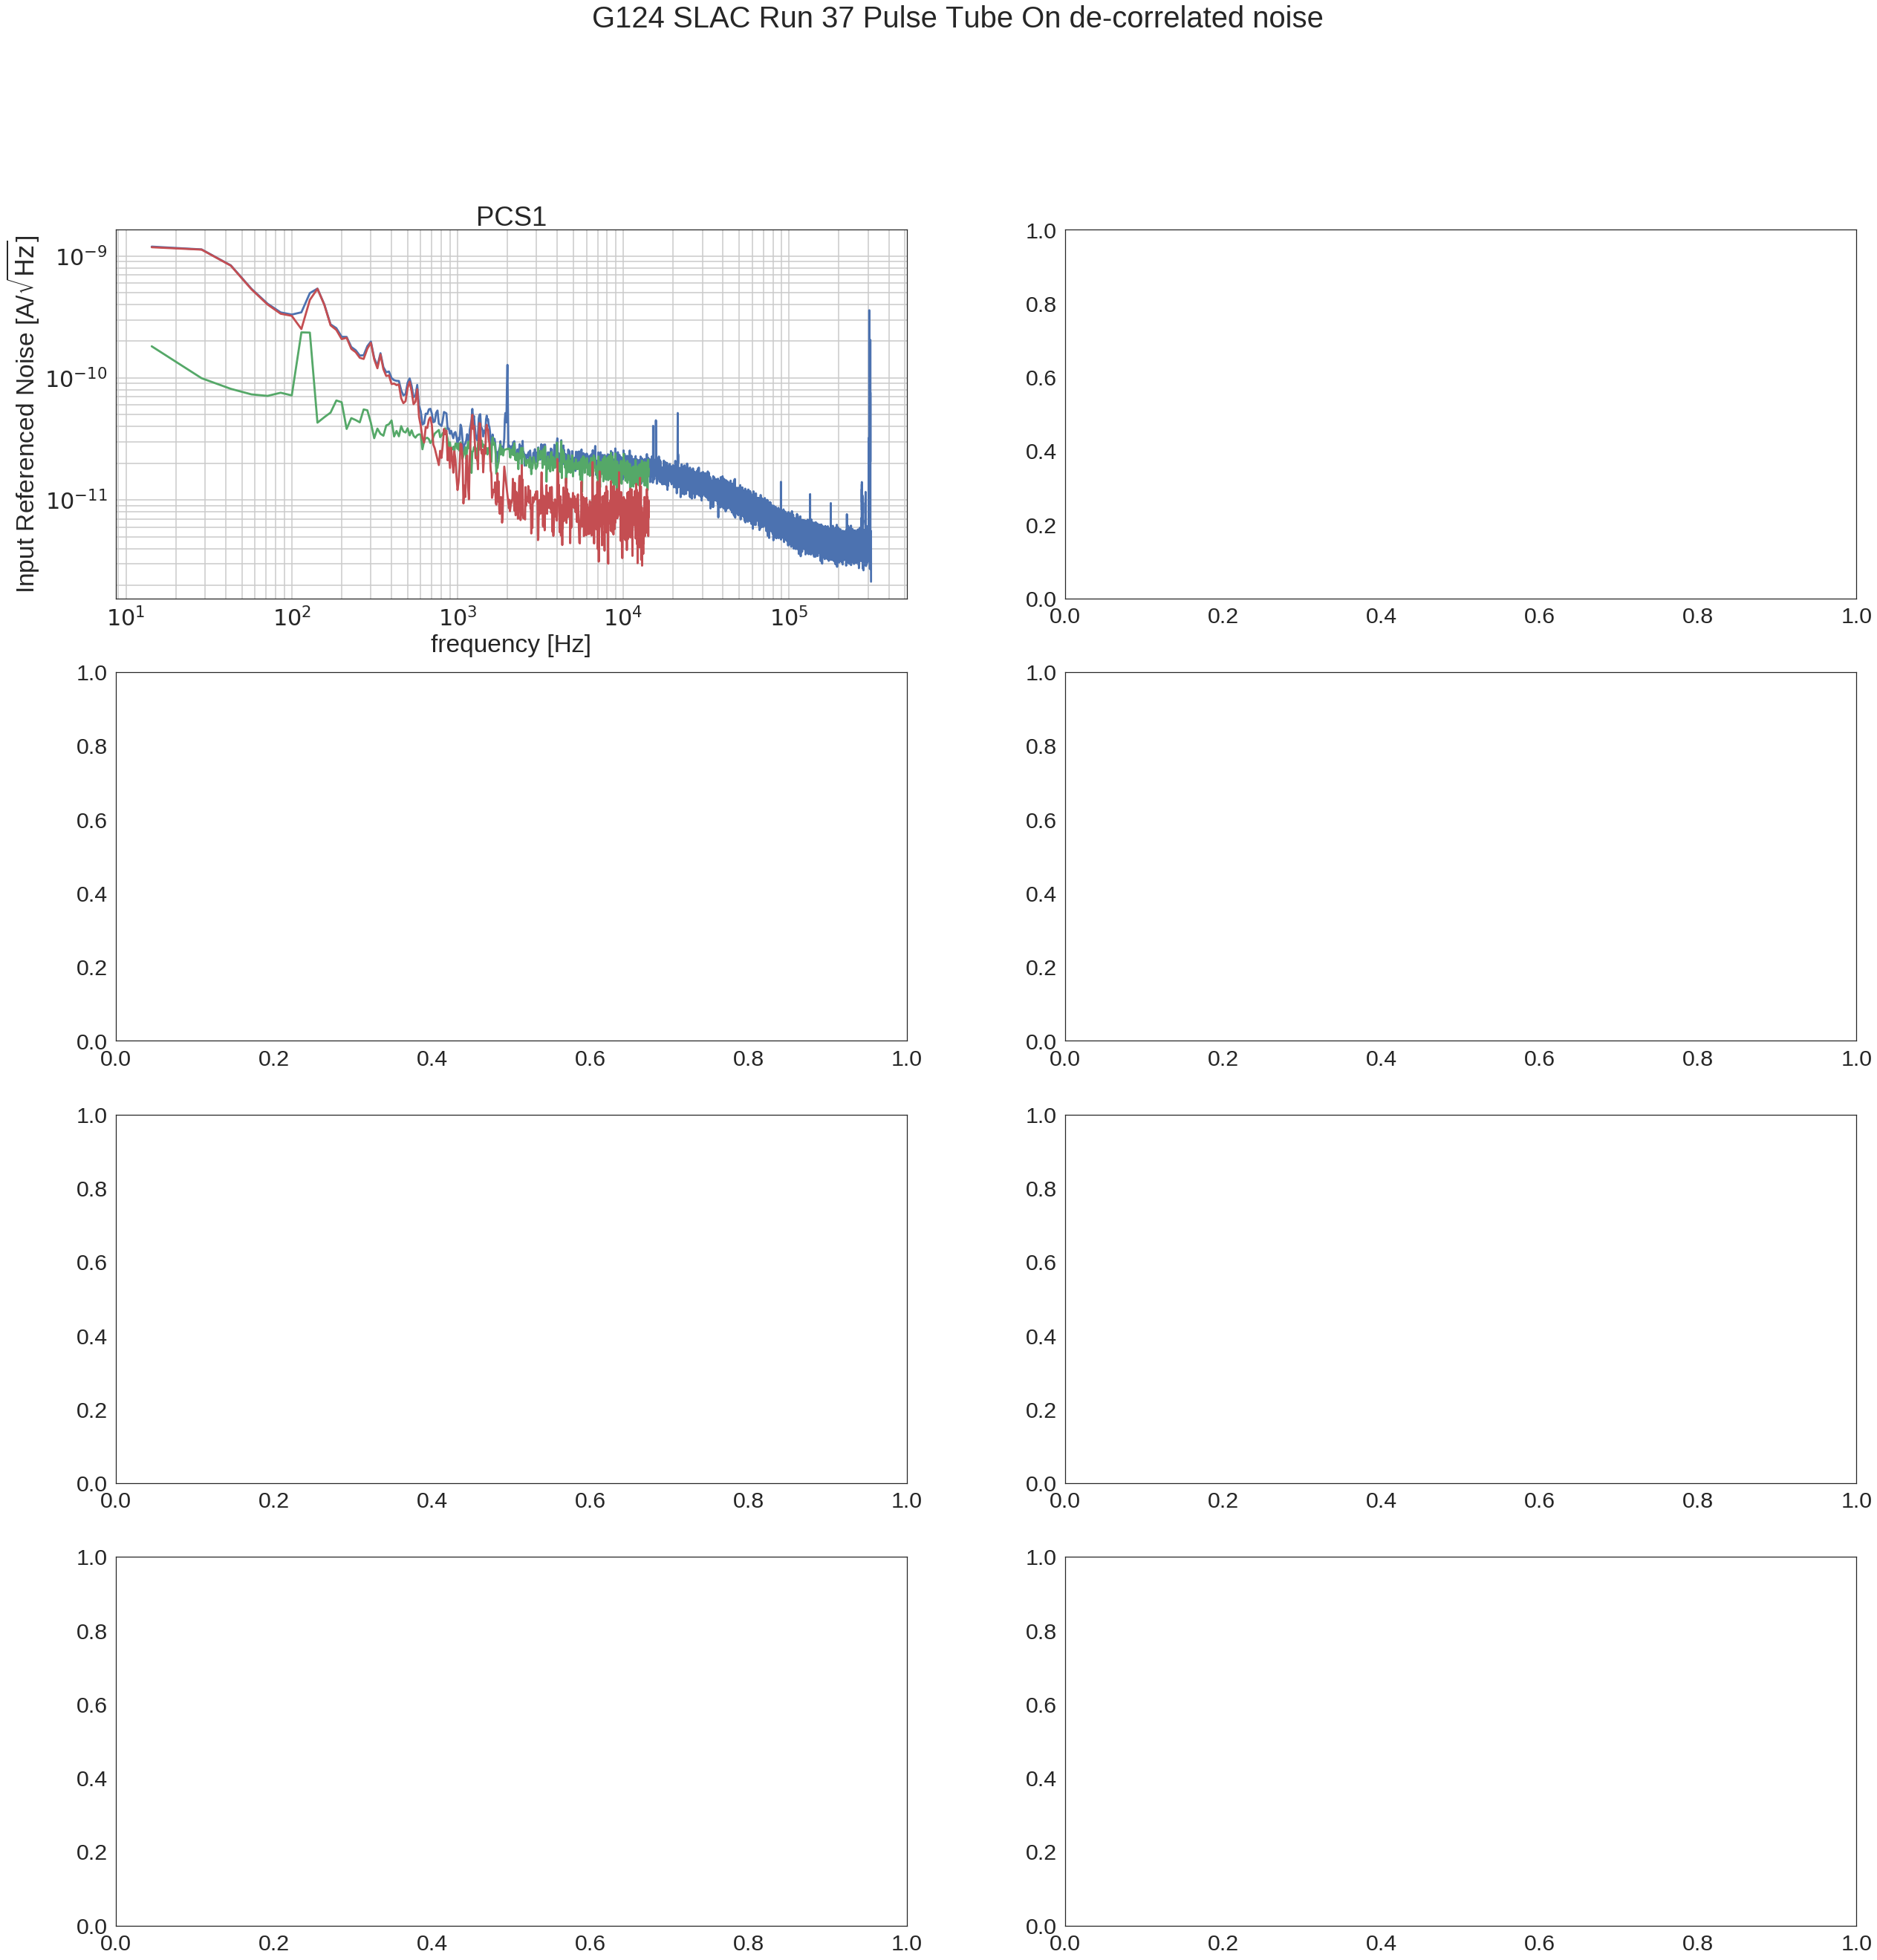

In [21]:
g124_noise.plot_deCorrelatedNoise(lgcCorrelated=True, lgcSum=True)


### Test Plotting of PSD and correlation coefficients

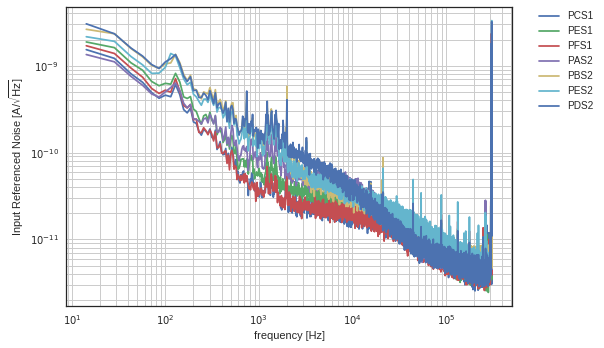

In [6]:
g124_noise.plot_PSD(lgc_overlay=True)

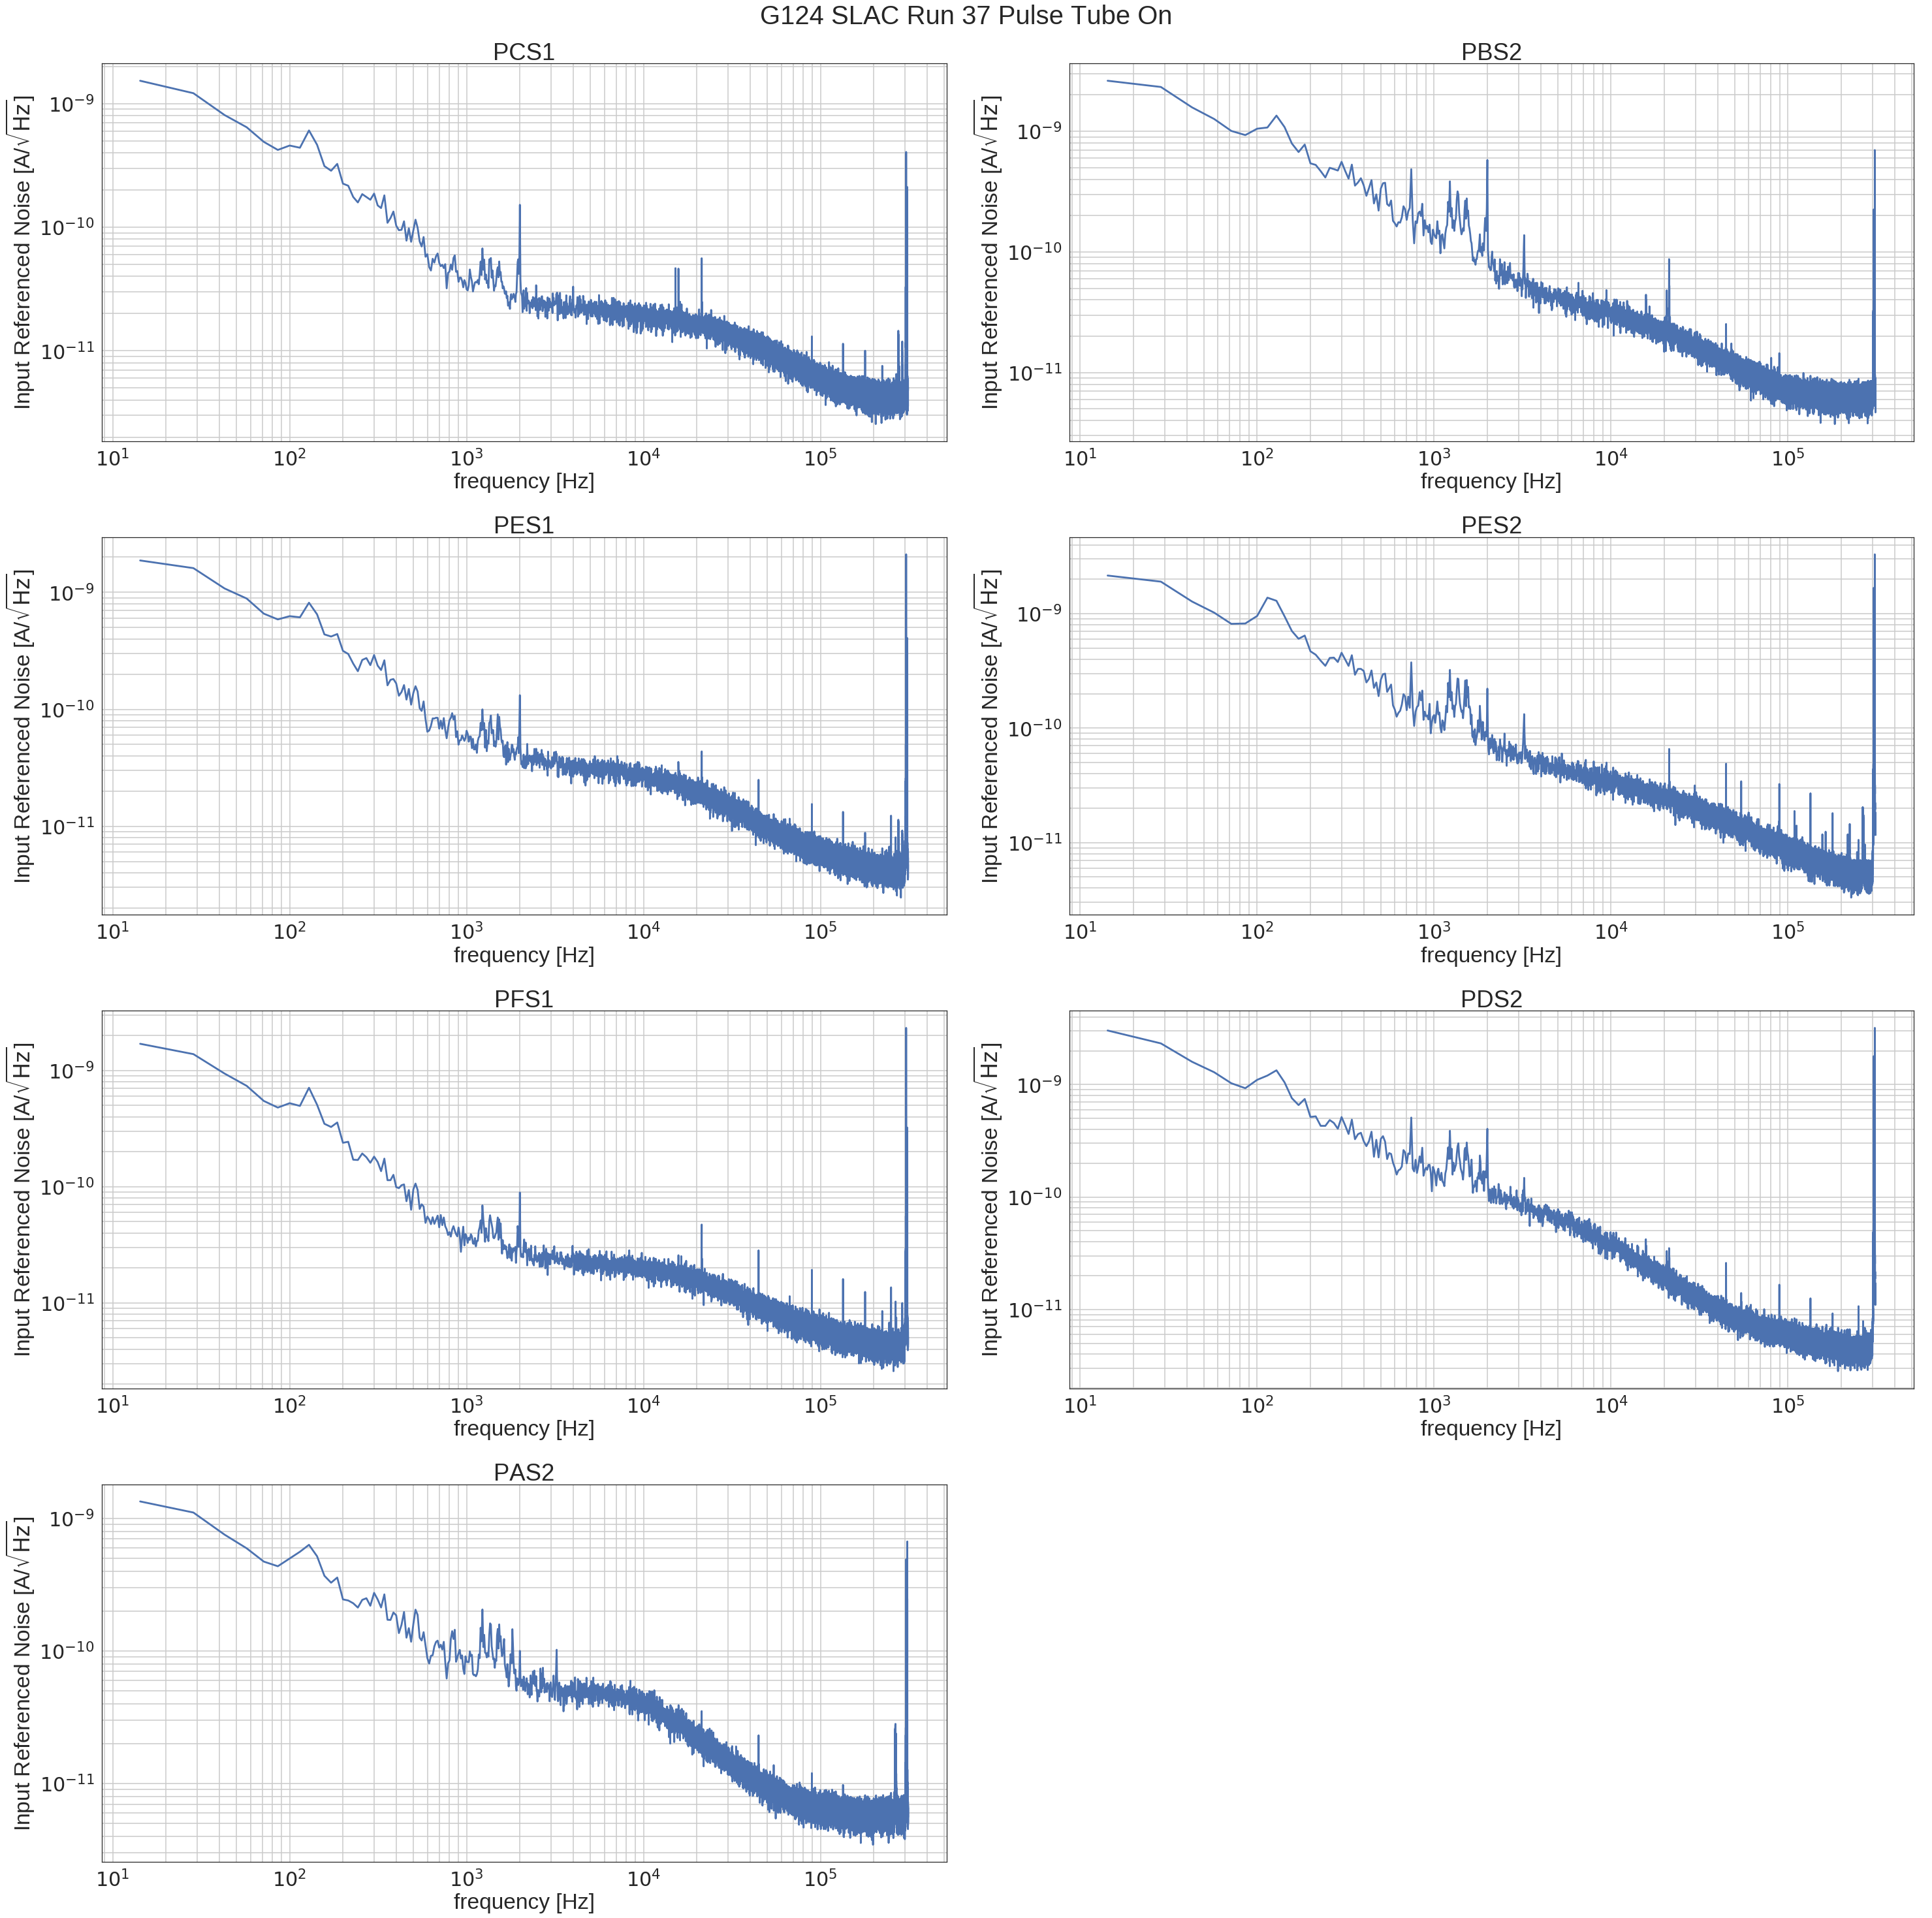

In [7]:
g124_noise.plot_PSD(lgc_overlay=False)


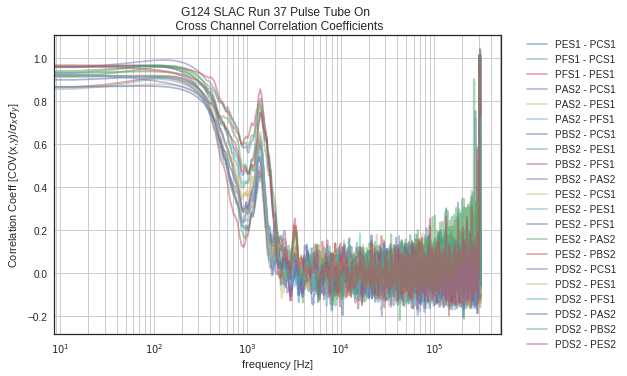

In [7]:
g124_noise.plot_corrCoef()

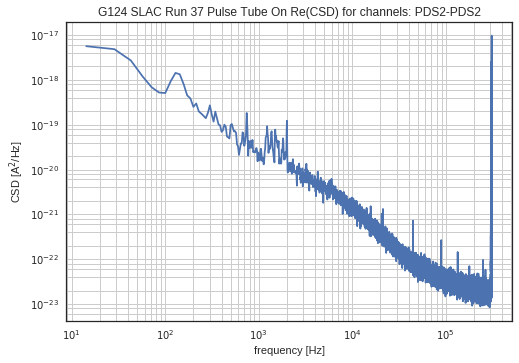

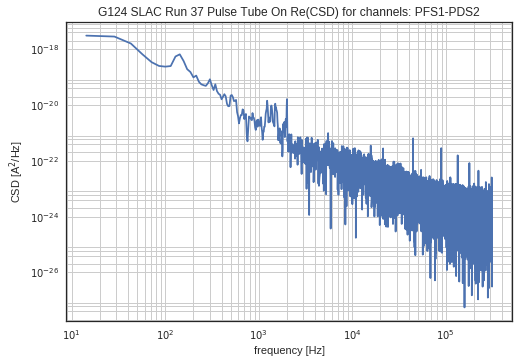

In [9]:
g124_noise.plot_CSD(whichCSD=['66','26'])

In [8]:
g124_noise.real_CSD.shape[0]

7